# Data exploratory work on the food recognition challenge task


## Setting up

In [3]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 5.7MB/s 


In [4]:

#Pythonstuff
import pandas as pd
import numpy as np
from PIL import Image
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#Imagestuff
import cv2
from google.colab.patches import cv2_imshow
import albumentations as A
from tensorflow.keras.layers.experimental import preprocessing

#Google Colab
from google.colab import drive

#Keras
#Import from keras_preprocessing not from keras.preprocessing
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
#from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
#from keras.layers import Conv2D, MaxPooling2D
#from keras import regularizers, optimizers
#from keras import utils
import efficientnet.keras as efn
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB5

drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Constants and parameters

In [25]:
#Constants and parameters

#file system
BASE_DIR = "data/"
DATA_USAGE_RATIO = 1. # 1. for 100%

#image data
IMG_SIZE = 224
IMG_DIM = (IMG_SIZE,IMG_SIZE)
SCALE_RATIO=1./255.

#random seed
SEED = 40

#model
BATCH_SIZE = 32
NUM_CLASSES = 80
EPOCHS = 50
TRAIN_RATIO = 0.10
WEIGHTS='noisy-student'
TOP_DROPOUT_RATE = 0.5
ACTIVATION = "softmax"
LOSS_FUNCTION = "categorical_crossentropy"

MIN_DELTA = 0.01 #if change less than 1% in accuracy, stop training.

TOP_LAYERS = 20 #number of layers to unfreeze

#learning rate
START_LR = 0.00001
MIN_LR = 0.00001
MAX_LR = 0.0005 
RAMPUP_EPOCHS = 3
SUSTAIN_EPOCHS = 2
EXP_DECAY = .6

## Getting the data

In [ ]:
# download and unzip locally

downzip=True
if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

mkdir: cannot create directory ‘data’: File exists
/content/data
--2020-12-11 11:51:06--  https://docs.google.com/uc?export=download&confirm=ybjX&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV
Resolving docs.google.com (docs.google.com)... 172.217.204.138, 172.217.204.102, 172.217.204.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-70-docs.googleusercontent.com/docs/securesc/gdbdd5b20j2sd76a1q8i7eevr3oldjen/perfc3142p5j1vqb24p3hdmhkpm5li98/1607687400000/10490392775048702533/05129799610457372680Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download [following]
--2020-12-11 11:51:07--  https://doc-0k-70-docs.googleusercontent.com/docs/securesc/gdbdd5b20j2sd76a1q8i7eevr3oldjen/perfc3142p5j1vqb24p3hdmhkpm5li98/1607687400000/10490392775048702533/05129799610457372680Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download
Resolving doc-0k-70-docs.googleusercontent.com (doc-0k-70-docs.google

In [ ]:


def append_ext(fn):
    return fn+".png"
    
traindf=pd.read_csv(BASE_DIR+"train_labels.csv")
X = BASE_DIR + "train_set/train_set/" + traindf.img_name.values
y = traindf.label.values - 1

testdf = pd.read_csv(BASE_DIR+'sample.csv')
testX = BASE_DIR + "test_set/test_set/"+testdf.img_name.values
testy = testdf.label.values - 1

#train, test, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=1)

num_classes = 80
#y_train = utils.to_categorical(train_y, num_classes)

##Image Augmentation Tests

data/train_set/train_set/train_6.jpg


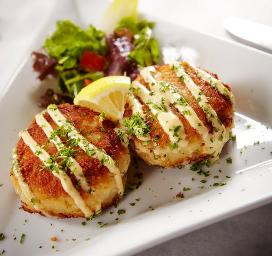

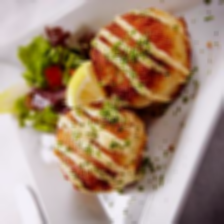

In [ ]:
print(X[5])
im = cv2.imread(X[1])

cv2_imshow(im)
# Declare an augmentation pipeline
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
    A.RandomCrop(width=IMG_SIZE/2, height=IMG_SIZE/2, p=0.05),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.5),
    A.JpegCompression(quality_lower=85, quality_upper=100, p=0.2),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.1),
    A.HorizontalFlip(),
    A.RandomRotate90(p=0.2),
    A.Blur(p=0.1)
])

# Read an image with OpenCV and convert it to the RGB colorspace

# Augment an image
transformed = transform(image=im)
transformed_image = transformed["image"]
cv2_imshow(transformed_image)


In [ ]:
testX[1]

#np.where(train=="drive/MyDrive/final-project-food-recognition-challenge.zip (Unzipped Files)/train_set/train_set/train_716.jpg")[0]

'data/test_set/test_set/test_2.jpg'

##Parse in images

In [ ]:

traindf = pd.DataFrame()
testdf = pd.DataFrame()

traindf["y"] = y.astype(str)
testdf["y"] = testy.astype(str)
traindf["X"] = X
testdf["X"] = testX



###downsample images

In [ ]:
traindf = traindf[:int(len(traindf)*DATA_USAGE_RATIO)]
print(len(traindf))


30612


###define generators for dataflow

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-8d_e0ujx
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-8d_e0ujx
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=28175 sha256=287ce7cc4e953b605bc0f0009ee8c730a45a7b174c48ccef29d47d90da4128a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-akapxih6/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor


In [ ]:

#define generators for dataflow

#initialite ImageDataGenerator. Optionally, this can handle augmentation itself or apply a preprocessing function like albumentations

from ImageDataAugmentor.image_data_augmentor import *

AUGMENTATIONS = A.Compose([
    A.Transpose(p=0.2),
    A.RandomContrast(p=0.2),
    A.VerticalFlip(p=0.3),
    #A.RandomCrop(10,10,p=0.1),
    A.Flip(p=0.5),
    A.Cutout(p=0.5),
    A.ShiftScaleRotate(p=0.5),  #default rotations is 45degree + shift height and width with the limit amount of 0.0625
    A.OneOf([
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=1),
    A.Blur(p=0.02),
    A.HueSaturationValue(p=0.2),
    A.RGBShift(p=0.4),
])

train_datagen = ImageDataAugmentor(
        rescale=SCALE_RATIO,
        augment = AUGMENTATIONS,
        preprocess_input=None)
        
valid_datagen = ImageDataAugmentor(rescale=SCALE_RATIO, validation_split=TRAIN_RATIO)

datagen=ImageDataGenerator(rescale=SCALE_RATIO, validation_split=TRAIN_RATIO) #preprocessing_function=transform)   #preprocessing_function=


train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
x_col="X",
y_col="y",
subset="training",
batch_size=BATCH_SIZE,
seed=SEED,
shuffle=True,
class_mode="categorical",
target_size=IMG_DIM)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=traindf,
x_col="X",
y_col="y",
subset="validation",
batch_size=BATCH_SIZE,
seed=SEED,
shuffle=True,
class_mode="categorical",
target_size=IMG_DIM)

test_datagen=ImageDataGenerator(rescale=SCALE_RATIO)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
x_col="X",
y_col="y",
batch_size=1,
seed=SEED,
shuffle=False,
class_mode=None,
target_size=IMG_DIM)


Found 30612 validated image filenames belonging to 80 classes.
Found 3061 validated image filenames belonging to 80 classes.
Found 7653 validated image filenames.


## Augmentation

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)



transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
    A.RandomCrop(width=IMG_SIZE/2, height=IMG_SIZE/2, p=0.05),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.5),
    A.JpegCompression(quality_lower=85, quality_upper=100, p=0.2),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.1),
    A.HorizontalFlip(),
    A.RandomRotate90(p=0.2),
    A.Blur(p=0.1)
])



## Train a model

###variable learning rate


Learning rate per epoch:


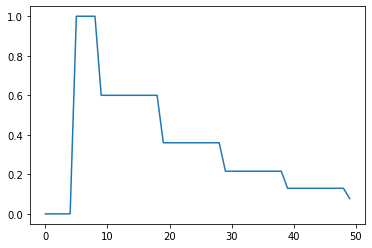

In [26]:
import math

def lrfn(epoch):
  if epoch < RAMPUP_EPOCHS:
    return (MAX_LR - START_LR)/RAMPUP_EPOCHS * epoch + START_LR
  elif epoch < RAMPUP_EPOCHS + SUSTAIN_EPOCHS:
    return MAX_LR
  else:
    return math.pow(EXP_DECAY, math.floor((1+epoch)/10)) + MIN_LR

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

###model training function

In [ ]:
# fits the model on batches with real-time data augmentation:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    model = efn.EfficientNetB0(include_top=False, input_tensor=x, weights=WEIGHTS) 
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(TOP_DROPOUT_RATE, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation=ACTIVATION, name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss=LOSS_FUNCTION, metrics=["accuracy"]
    )
    return model

### Plot & evaluation output functions


In [ ]:
def plot_hist(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [ ]:
#!/usr/local/cuda/bin/nvcc --version
#!nvidia-smi

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5",verbose=1,save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=MIN_DELTA,mode = 'min', #when change is less than MIN_DELTA
    patience=5,verbose = 0, restore_best_weights = True)
]

with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)
#model.summary() 

hist = model.fit(train_generator, 
                 epochs=EPOCHS,
                 validation_data=valid_generator,
                 callbacks=callbacks, 
                 verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
957/957 [==============================] - ETA: 0s - loss: 5.8937 - accuracy: 0.0163
Epoch 00001: val_loss improved from inf to 4.82930, saving model to save_at_1.h5
957/957 [==============================] - 198s 207ms/step - loss: 5.8937 - accuracy: 0.0163 - val_loss: 4.8293 - val_accuracy: 0.0219

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017333333333333334.
Epoch 2/50
957/957 [==============================] - ETA: 0s - loss: 4.4076 - accuracy: 0.1031
Epoch 00002: val_loss improved from 4.82930 to 2.56533, saving model to save_at_2.h5
957/957 [==============================] - 193s 202ms/step - loss: 4.4076 - accuracy: 0.1031 - val_loss: 2.5653 - val_accuracy: 0.3790

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0003366666666666667.
Epoch 3/50
957/957 [==============================] - ETA: 0s - loss: 3.3764 - accuracy: 0.2352
Epoch 00003: val_loss improved from 

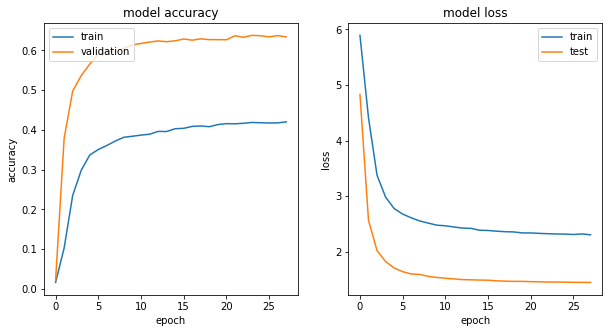

In [ ]:
plot_hist(hist)

How are we doing so far?

In [ ]:
loss, accuracy = model.evaluate(valid_generator)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

96/96 [==============================] - 10s 104ms/step - loss: 1.4548 - accuracy: 0.6331
Validation: accuracy = 0.633126  ;  loss = 1.454782 


### unfreeze and retrain last 20 layers


In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-TOP_LAYERS:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = EPOCHS  
hist = model.fit(train_generator, epochs=EPOCHS, callbacks=callbacks, validation_data=valid_generator, verbose=1)



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
957/957 [==============================] - ETA: 0s - loss: 2.2975 - accuracy: 0.4221
Epoch 00001: val_loss improved from 1.44792 to 1.43014, saving model to save_at_1.h5
957/957 [==============================] - 193s 201ms/step - loss: 2.2975 - accuracy: 0.4221 - val_loss: 1.4301 - val_accuracy: 0.6374

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017333333333333334.
Epoch 2/50
957/957 [==============================] - ETA: 0s - loss: 2.2297 - accuracy: 0.4391
Epoch 00002: val_loss improved from 1.43014 to 1.33740, saving model to save_at_2.h5
957/957 [==============================] - 189s 197ms/step - loss: 2.2297 - accuracy: 0.4391 - val_loss: 1.3374 - val_accuracy: 0.6576

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0003366666666666667.
Epoch 3/50
957/957 [==============================] - ETA: 0s - loss: 2.1351 - accuracy: 0.4608
Epoch 00003: val_loss improved f

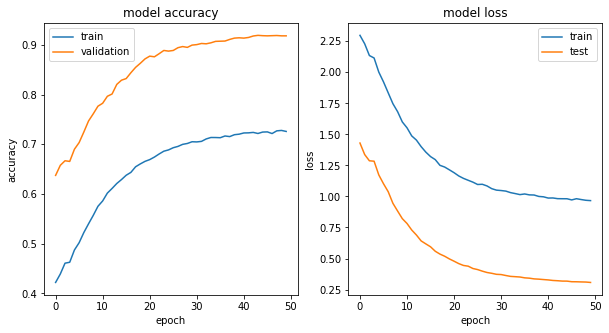

In [ ]:
plot_hist(hist)

## final verdict


In [ ]:
savloss, accuracy = model.evaluate(valid_generator)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

96/96 [==============================] - 10s 101ms/step - loss: 0.3071 - accuracy: 0.9180
Validation: accuracy = 0.918001  ;  loss = 0.307113 


## reset generator & save results

In [ ]:
test_generator.reset()

pred=model.predict(test_generator,
steps=test_generator.n//test_generator.batch_size,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

7653/7653 [==============================] - 90s 12ms/step


In [ ]:
model.save('EfficientnetB0CustomAug')


NameError: ignored